<a href="https://colab.research.google.com/github/ella00100/Kaggle_competition/blob/main/Home_Credit_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction to Manual Feature Engineering

- 이 노트북에서는 홈 크레딧 기본 위험 경쟁을 위한 기능을 직접 만드는 방법에 대해 알아봅니다. 이전 노트북에서는 모델을 구축하기 위해 애플리케이션 데이터만 사용했습니다. 우리가 이 데이터에서 만든 최고의 모델은 리더보드에서 약 0.74점을 얻었습니다. 이 점수를 개선하려면 다른 데이터 프레임의 정보를 더 많이 포함해야 합니다. 

- 여기서는 Bureau의 정보와 Bureau_balance 데이터를 사용하는 방법을 살펴보겠습니다. 이러한 데이터 파일의 정의는 다음과 같습니다:

- Bureau: 고객이 Home Credit에 보고한 다른 금융 기관과의 이전 대출에 대한 정보. 이전 대출에는 각각의 행이 있습니다.

- bureau_balance: 이전 대출에 대한 월별 정보. 각 달에는 고유한 행이 있습니다.
manual feature engineering은 지루한 프로세스가 될 수 있으며(기능 툴과 함께 자동화된 기능 엔지니어링을 사용하는 이유입니다!) 종종 도메인 전문 지식에 의존합니다. 대출에 대한 도메인 지식과 채무 불이행 가능성을 높이는 요소가 제한되어 있기 때문에, 대신 최종 교육 데이터 프레임에 가능한 한 많은 정보를 얻는 데 집중할 것입니다. 그 아이디어는 모델이 우리가 결정해야 하는 것보다 어떤 기능이 중요한지 알게 될 것이라는 것입니다. 기본적으로, 우리의 접근 방식은 가능한 한 많은 기능을 만든 다음 이 모든 기능을 모델이 사용하도록 제공하는 것입니다! 나중에 모델의 기능 중요도나 PCA와 같은 다른 기술을 사용하여 기능 축소를 수행할 수 있습니다.

- manual feature engineering 프로세스에는 많은 Pandas 코드, 약간의 인내심 및 많은 우수한 연습 조작 데이터가 포함됩니다. 자동화된 기능 엔지니어링 도구를 사용할 수 있게 되기 시작했지만, 기능 엔지니어링은 여전히 많은 데이터 논쟁을 사용하여 잠시 동안 수행해야 합니다.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

## Ex: Counts of a client's previous loans

- manual feature engineering의 일반적인 프로세스를 설명하기 위해 먼저 다른 금융 기관에서 고객의 이전 대출 금액을 간단히 계산합니다. 이를 위해서는 노트북 전체에 걸쳐 많은 Pandas 작업이 필요합니다:

  - groupby: 데이터 프레임을 열별로 그룹화합니다. 이 경우 고유 고객인 SK_ID_CURR 열별로 그룹화합니다

  - agg: 열의 평균을 구하는 것과 같은 그룹화된 데이터에 대해 계산을 수행합니다. 함수(grouped_df.mean())를 직접 호출하거나 변환 목록(grouped_df.agg([mean, max, min, sum])과 함께 agg 함수를 사용할 수 있습니다

  - merge: 집계된 통계를 적절한 클라이언트와 일치시킵니다. 원래 교육 데이터를 SK의 계산된 통계와 병합해야 합니다클라이언트에 해당 통계가 없는 셀에 NaN을 삽입할 ID_CURR 열
또한 사전으로 이름을 바꿀 열을 지정하는 (이름 바꾸기) 기능을 상당히 많이 사용합니다. 이것은 우리가 생성하는 새로운 변수를 추적하는 데 유용합니다.

- 이것은 많은 것처럼 보일 수 있습니다. 그래서 우리는 결국 이 과정을 수행하기 위한 함수를 작성할 것입니다. 먼저 수작업으로 구현하는 방법을 살펴보겠습니다.

In [2]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c home-credit-default-risk
!ls

Saving kaggle.json to kaggle (1).json
home-credit-default-risk.zip: Skipping, found more recently modified local copy (use --force to force download)
 application_test.csv		      kaggle.json
 application_train.csv		      POS_CASH_balance.csv
 bureau_balance.csv		      previous_application.csv
 bureau.csv			      sample_data
 credit_card_balance.csv	      sample_submission.csv
 HomeCredit_columns_description.csv   test_bureau_corrs_removed.csv
 home-credit-default-risk.zip	      test_bureau_raw.csv
 installments_payments.csv	      train_bureau_corrs_removed.csv
'kaggle (1).json'		      train_bureau_raw.csv


In [3]:
!unzip home-credit-default-risk.zip

Archive:  home-credit-default-risk.zip
replace HomeCredit_columns_description.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: HomeCredit_columns_description.csv  
  inflating: POS_CASH_balance.csv    
  inflating: application_test.csv    
  inflating: application_train.csv   
  inflating: bureau.csv              
  inflating: bureau_balance.csv      
  inflating: credit_card_balance.csv  
  inflating: installments_payments.csv  
  inflating: previous_application.csv  
  inflating: sample_submission.csv   


In [4]:
bureau = pd.read_csv('bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [5]:
# bureau 데이터프레임을 'SK_ID_CURR'로 그룹화하고, 'SK_ID_BUREAU'열을 count하여 'previous_loan_counts'라는 새로운 열을 생성
previous_loan_counts = bureau.groupby(
    'SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})

previous_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [6]:
train = pd.read_csv('application_train.csv')

#이전 대출 횟수 정보를 'train' 데이터프레임과 합침침
train = train.merge(previous_loan_counts, on = 'SK_ID_CURR', how='left')

#'previous_loan_counts' 열에서 결측값이 있으면 0
train['previous_loan_counts'] = train['previous_loan_counts'].fillna(0)
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,previous_loan_counts
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### r값을 이용한 새로운 변수의 유용성 평가
- 새 변수가 유용한지 여부를 확인하기 위해 이 변수와 목표값 사이의 피어슨 상관 계수(r-값)를 계산할 수 있습니다. 이 값은 두 변수 사이의 선형 관계의 강도를 측정하며 -1(완전히 음의 선형)에서 +1(완전히 양의 선형)까지의 범위를 갖습니다. 

- r-값은 새 변수의 "유용성"에 대한 최상의 척도는 아니지만 변수가 기계 학습 모델에 도움이 되는지 여부에 대한 첫 번째 근사치를 제공할 수 있습니다. 목표값에 대한 변수의 r-값이 클수록 이 변수의 변화는 목표값에 더 많은 영향을 미칠 수 있습니다. 따라서 목표값과 관련하여 절대값 r-값이 가장 큰 변수를 찾습니다.

- 또한 커널 밀도 추정(KDE) 그림을 사용하여 대상과의 관계를 시각적으로 검사할 수 있습니다.

#### Kernel Density Estimate Plots

- 커널 밀도 추정치 그림은 단일 변수의 분포를 보여줍니다(평활 히스토그램이라고 생각). 범주형 변수의 값에 따라 다른 분포를 보려면 범주에 따라 분포에 색을 다르게 지정할 수 있습니다. 예를 들어 TARGET = 1인지 0인지에 따라 색상이 지정된 이전_count_count의 커널 밀도 추정치를 표시할 수 있습니다. 결과 KDE는 대출금을 상환하지 않은 사람(TARGET == 1)과 상환한 사람(TARGET == 0) 간의 변수 분포에서 유의한 차이를 보여줍니다. 이는 변수가 기계 학습 모델과 '관련성'이 있는지 여부를 나타내는 지표가 될 수 있습니다.

In [7]:
def kde_target(var_name, df):
  '''
  변수의 TARGET과의 상관 관계를 계산하고, 
  TARGET 값이 0인 경우와 1인 경우 각각의 변수 분포를 비교하여 시각화
  '''
  #상관관계 계산 
  corr = df['TARGET'].corr(df[var_name])
  
  #target이 1인 경우와 0인 경우의 각각의 중앙값
  avg_repaid = df.loc[df['TARGET']==0, var_name].median()
  avg_not_repaid = df.loc[df['TARGET']==1, var_name].median()

  #kde plot 생성성
  plt.figure(figsize=(12,6))
  sns.kdeplot(df.loc[df['TARGET']==0, var_name], label = 'TARGET == 0')
  sns.kdeplot(df.loc[df['TARGET']==1, var_name], label = 'TARGET == 1')

  plt.xlabel(var_name)
  plt.ylabel('Density')
  plt.title('%s Distribution' %var_name)
  plt.legend()

  print('The correlation between %s and the TARGET is %0.4f' %(var_name, corr))
  print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
  print('Median value for loan that was repaid     = %0.4f' %avg_repaid)

랜덤 포레스트 및 그라데이션 부스팅 머신에 따르면 가장 중요한 변수 중 하나인 EXT_SOURCE_3 변수를 사용하여 이 함수를 테스트할 수 있습니다.

The correlation between EXT_SOURCE_3 and the TARGET is -0.1789
Median value for loan that was not repaid = 0.3791
Median value for loan that was repaid     = 0.5460


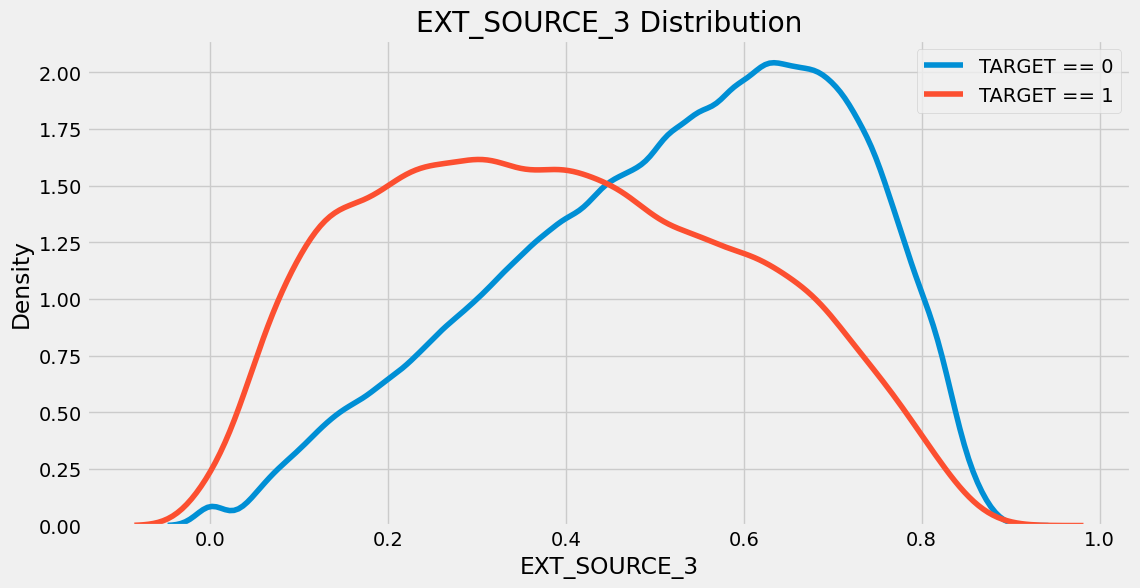

In [8]:
kde_target('EXT_SOURCE_3', train)

이제 우리가 방금 만든 새로운 변수, 다른 기관의 이전 대출 수를 보겠습니다.

The correlation between previous_loan_counts and the TARGET is -0.0100
Median value for loan that was not repaid = 3.0000
Median value for loan that was repaid     = 4.0000


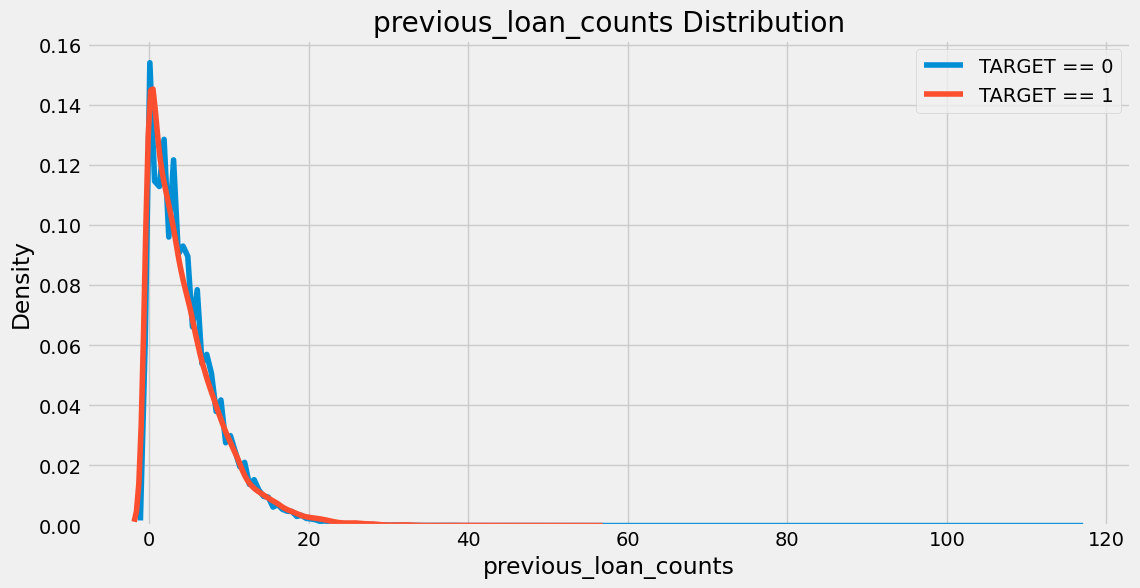

In [9]:
kde_target('previous_loan_counts', train)

- 이로 인해 이 변수가 중요한지 여부를 판단하기가 어렵습니다. 상관 계수는 매우 약하며 분포에서 거의 눈에 띄는 차이가 없습니다.

- 다음으로 bureau 데이터 프레임에서 몇 가지 변수를 더 만들어 보겠습니다. bureau 데이터 프레임에 있는 모든 숫자 열의 평균, 최소값 및 최대값을 사용합니다.

## Aggregating Numeric Columns

 - bureau 데이터 프레임의 숫자 정보를 설명하기 위해 모든 숫자 열에 대한 통계를 계산할 수 있습니다. 
 
 - 이를 위해 클라이언트 ID별로 그룹화하고 그룹화된 데이터 프레임을 집계한 후 결과를 교육 데이터에 다시 병합합니다. 
 
 - agg 함수는 작업이 유효한 것으로 간주되는 숫자 열의 값만 계산합니다. 우리는 'mean', 'max', 'min', 'sum'을 계속 사용할 것이지만, 여기에는 어떤 기능도 전달될 수 있습니다. 우리는 우리 자신의 기능을 작성하여 agg 호출에 사용할 수도 있습니다.

In [10]:
# 'SK_ID_BUREAU' 열을 삭제하고 'SK_ID_CURR'을 기준으로 그룹화하고,
# count, mean, max, sum  계산하여 bureau_agg 생성성

bureau_agg = bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index = False
                                                             ).agg(['count', 'mean', 'max', 'sum']).reset_index()
bureau_agg.head()

SK_ID_CURR DAYS_CREDIT                         CREDIT_DAY_OVERDUE           \
                   count         mean  max   sum              count mean max   
0     100001           7  -735.000000  -49 -5145                  7  0.0   0   
1     100002           8  -874.000000 -103 -6992                  8  0.0   0   
2     100003           4 -1400.750000 -606 -5603                  4  0.0   0   
3     100004           2  -867.000000 -408 -1734                  2  0.0   0   
4     100005           3  -190.666667  -62  -572                  3  0.0   0   

      DAYS_CREDIT_ENDDATE  ... AMT_CREDIT_SUM_OVERDUE      DAYS_CREDIT_UPDATE  \
  sum               count  ...                    max  sum              count   
0   0                   7  ...                    0.0  0.0                  7   
1   0                   6  ...                    0.0  0.0                  8   
2   0                   4  ...                    0.0  0.0                  4   
3   0                   2  ...                    0.0  0.0                  2   
4   0                   3  ...                    0.0  0.0                  3   

                         AMT_ANNUITY                                 
         mean  max   sum       count         mean      max      sum  
0  -93.142857   -6  -652           7  3545.357143  10822.5  24817.5  
1 -499.875000   -7 -3999           7     0.000000      0.0      0.0  
2 -816.000000  -43 -3264           0          NaN      NaN      0.0  
3 -532.000000 -382 -1064           0          NaN      NaN      0.0  
4  -54.333333  -11  -163           3  1420.500000   4261.5   4261.5  

[5 rows x 49 columns]

- 각 열에 대해 새 이름을 만들어야 합니다. 다음 코드는 이름에 통계를 추가하여 새 이름을 만듭니다. 

- 여기서 우리는 데이터 프레임에 다단계 인덱스가 있다는 사실을 다루어야 합니다. 저는 이런 것들이 혼란스럽고 다루기가 어렵다고 생각하기 때문에 가능한 한 빨리 단일 수준의 색인으로 줄이려고 노력합니다.

In [11]:
#bureau_agg 데이터프레임에서 각 변수 별로 count, mean, max, sum을 계산한 결과를 가지고 
#새로운 변수명을 생성하고 이를 columns 리스트에 추가

columns = ['SK_ID_CURR']

for var in bureau_agg.columns.levels[0]:
  if var != 'SK_ID_CURR':
    #각 변수마다 count, mean, max, sum을 계산한 결과에 대해서, 
    #새로운 변수명을 생성하고 columns 리스트에 추가
    for stat in bureau_agg.columns.levels[1][:-1]:
      columns.append('bureau_%s_%s' %(var, stat))

In [12]:
bureau_agg.columns = columns
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,...,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-5145,7,0.0,0,0,7,...,0.0,0.0,7,-93.142857,-6,-652,7,3545.357143,10822.5,24817.5
1,100002,8,-874.000000,-103,-6992,8,0.0,0,0,6,...,0.0,0.0,8,-499.875000,-7,-3999,7,0.000000,0.0,0.0
2,100003,4,-1400.750000,-606,-5603,4,0.0,0,0,4,...,0.0,0.0,4,-816.000000,-43,-3264,0,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1734,2,0.0,0,0,2,...,0.0,0.0,2,-532.000000,-382,-1064,0,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-572,3,0.0,0,0,3,...,0.0,0.0,3,-54.333333,-11,-163,3,1420.500000,4261.5,4261.5


- 이제 이전과 같이 교육 데이터와 병합합니다

In [13]:
train = train.merge(bureau_agg, on='SK_ID_CURR', how='left')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,8.0,-499.875,-7.0,-3999.0,7.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,4.0,-816.000,-43.0,-3264.0,0.0,NaN,NaN,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,2.0,-532.000,-382.0,-1064.0,0.0,NaN,NaN,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,1.0,-783.000,-783.0,-783.0,0.0,NaN,NaN,0.0


### Correlations of Aggregated Values with Target

- 우리는 모든 새로운 값과 목표값의 상관관계를 계산할 수 있습니다. 다시, 우리는 이것들을 모델링에 중요할 수 있는 변수의 근사치로 사용할 수 있습니다.

In [14]:
new_corrs = []

for col in columns:
  corr = train['TARGET'].corr(train[col])
  new_corrs.append((col, corr))

- 아래 코드에서는 정렬된 Python 함수를 사용하여 크기(절대값)에 따라 상관관계를 정렬합니다. 우리는 또한 알아두면 좋은 또 다른 중요한 파이썬 작업인 익명 람다 함수를 사용합니다.

In [15]:
new_corrs = sorted(new_corrs, key=lambda x:abs(x[1]), reverse = True)
new_corrs[:15]

[('bureau_DAYS_CREDIT_mean', 0.08972896721998116),
 ('bureau_DAYS_CREDIT_UPDATE_mean', 0.06892735266968675),
 ('bureau_DAYS_CREDIT_ENDDATE_sum', 0.053734895601020544),
 ('bureau_DAYS_ENDDATE_FACT_mean', 0.053199625857586336),
 ('bureau_DAYS_CREDIT_max', 0.04978205463997308),
 ('bureau_DAYS_ENDDATE_FACT_sum', 0.04885350261111596),
 ('bureau_DAYS_CREDIT_ENDDATE_mean', 0.04698275433483542),
 ('bureau_DAYS_CREDIT_sum', 0.04199982481484676),
 ('bureau_DAYS_CREDIT_UPDATE_sum', 0.04140363535306015),
 ('bureau_DAYS_CREDIT_ENDDATE_max', 0.03658963469632896),
 ('bureau_DAYS_ENDDATE_FACT_count', -0.030492306653325526),
 ('bureau_DAYS_CREDIT_UPDATE_max', 0.028233546896535858),
 ('bureau_AMT_CREDIT_SUM_mean', -0.01995656190230458),
 ('bureau_AMT_CREDIT_SUM_max', -0.019737496507844256),
 ('bureau_DAYS_ENDDATE_FACT_max', 0.0196439250133316)]

- 새 변수 중 대상과 유의한 상관 관계가 있는 변수가 없습니다. 상관관계가 가장 높은 변수인 bureau_의 KDE 그림을 볼 수 있습니다DAYS_Credit_mean(대상이 절대 크기 상관 관계)입니다.

The correlation between bureau_DAYS_CREDIT_mean and the TARGET is 0.0897
Median value for loan that was not repaid = -835.3333
Median value for loan that was repaid     = -1067.0000


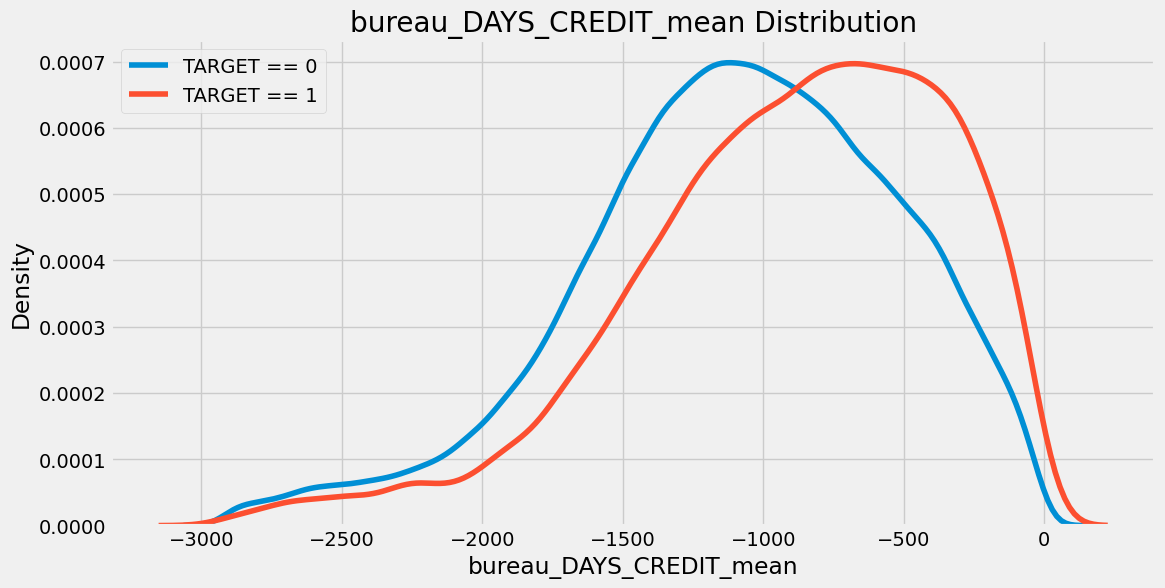

In [16]:
kde_target('bureau_DAYS_CREDIT_mean', train)

- 이 변수는 "현재 대출 신청 전에 고객이 Credit Bureau credit을 신청한 일 수"를 나타냅니다. 

- 내 해석은 이것이 홈 크레딧에서 대출을 신청하기 전에 이전 대출을 가입한 날짜의 수입니다. 따라서 더 큰 음수는 대출이 현재 대출 신청보다 더 이전에 신청되었음을 나타냅니다. 

- 이 변수의 평균과 target 간에는 매우 약한 양의 관계가 있습니다. 이는 이전에 대출을 신청한 고객이 Home Credit 대출을 상환할 가능성이 높다는 것을 나타냅니다. 그러나 상관관계가 이렇게 약하면 신호(signal)일 가능성과 노이즈(noise)일 가능성이 동등하게 높습니다.

#### The Multiple Comparisons Problem

- 많은 변수가 있을 때, 우리는 그들 중 일부가 순전히 우연에 의해 상관 관계를 맺을 것으로 예상합니다. 

- 이는 다중 비교로 알려진 문제입니다. 우리는 수백 개의 기능을 만들 수 있으며, 일부 기능은 단순히 데이터의 무작위 노이즈 때문에 대상과 연관되어 있는 것으로 밝혀질 것입니다. 

- 그런 다음, 우리 모델이 훈련할 때, 훈련 세트의 대상과 관계가 있다고 생각하기 때문에 이러한 변수에 지나치게 적합할 수 있지만, 이것이 반드시 테스트 세트로 일반화되는 것은 아닙니다. 기능을 만들 때 고려해야 할 많은 고려 사항이 있습니다!

##Function for Numeric Aggregations

앞의 모든 작업을 함수로 캡슐화해 보겠습니다. 이를 통해 모든 데이터 프레임에서 숫자 열의 집계 통계를 계산할 수 있습니다. 다른 데이터 프레임에도 동일한 작업을 적용하고자 할 때 이 기능을 다시 사용합니다.


In [17]:
def agg_numeric(df, group_var, df_name):
  '''
  주어진 데이터프레임에서 수치형 열에 대한 집계 통계량을 계산하고, 
  지정된 그룹 변수(group_var)로 그룹화하여 결과를 반환
  '''
  for col in df:
    #group_var를 제외한 모든 'SK_ID'로 시작하는 열을 삭제
    if col != group_var and 'SK_ID' in col:
      df = df.drop(columns = col)
  
  group_ids = df[group_var]
  #number데이터만 선택
  numeric_df = df.select_dtypes('number')
  numeric_df[group_var] = group_ids

  #수치형 변수의 개수(count), 평균(mean), 최댓값(max), 최솟값(min), 합(sum)을 계산
  agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

  columns = [group_var]

  for var in agg.columns.levels[0]:
    if var != group_var:
      for stat in agg.columns.levels[1][:-1]:
        columns.append('%s_%s_%s' %(df_name, var, stat))
    
  agg.columns = columns
  return agg

In [18]:
bureau_agg_new = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg_new.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


기능이 의도한 대로 작동하는지 확인하려면 수작업으로 구축한 집계 데이터 프레임과 비교해야 합니다.

In [19]:
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,...,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-5145,7,0.0,0,0,7,...,0.0,0.0,7,-93.142857,-6,-652,7,3545.357143,10822.5,24817.5
1,100002,8,-874.000000,-103,-6992,8,0.0,0,0,6,...,0.0,0.0,8,-499.875000,-7,-3999,7,0.000000,0.0,0.0
2,100003,4,-1400.750000,-606,-5603,4,0.0,0,0,4,...,0.0,0.0,4,-816.000000,-43,-3264,0,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1734,2,0.0,0,0,2,...,0.0,0.0,2,-532.000000,-382,-1064,0,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-572,3,0.0,0,0,3,...,0.0,0.0,3,-54.333333,-11,-163,3,1420.500000,4261.5,4261.5


우리가 그 값들을 조사해 보면, 우리는 그것들이 동등하다는 것을 알게 됩니다. 우리는 이 기능을 다른 데이터 프레임에 대한 숫자 통계를 계산하는 데 재사용할 수 있습니다. 기능을 사용하면 일관된 결과를 얻을 수 있고 앞으로 해야 할 일의 양이 줄어듭니다!



####Correlation Function

다음으로 넘어가기 전에 대상과의 상관관계를 계산하는 코드를 함수로 만들 수도 있습니다.

In [20]:
def target_corrs(df):
  corrs = []
  for col in df.columns:
    print(col)
    if col != 'TARGET':
      corr = df['TARGET'].corr(df[col])
      corrs.append((col,corr))
  corrs = sorted(corrs, key=lambda x: abs(x[1]), reverse = True)

  return corrs

### Categorical Variables

이제 숫자 열에서 범주형 열로 이동합니다. 이러한 변수는 이산 문자열 변수이므로 숫자 변수에만 사용되는 평균 및 최대값과 같은 통계량을 계산할 수 없습니다. 대신 각 범주 변수 내에서 각 범주의 값 카운트를 계산합니다. 

In [21]:
categorical = pd.get_dummies(bureau.select_dtypes('object'))
categorical['SK_ID_CURR'] = bureau['SK_ID_CURR']
categorical.head()

,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,SK_ID_CURR
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354


In [22]:
categorical_grouped = categorical.groupby('SK_ID_CURR').agg(['sum', 'mean'])
categorical_grouped.head()

CREDIT_ACTIVE_Active           CREDIT_ACTIVE_Bad debt       \
                            sum      mean                    sum mean   
SK_ID_CURR                                                              
100001                        3  0.428571                      0  0.0   
100002                        2  0.250000                      0  0.0   
100003                        1  0.250000                      0  0.0   
100004                        0  0.000000                      0  0.0   
100005                        2  0.666667                      0  0.0   

           CREDIT_ACTIVE_Closed           CREDIT_ACTIVE_Sold       \
                            sum      mean                sum mean   
SK_ID_CURR                                                          
100001                        4  0.571429                  0  0.0   
100002                        6  0.750000                  0  0.0   
100003                        3  0.750000                  0  0.0   
100004                        2  1.000000                  0  0.0   
100005                        1  0.333333                  0  0.0   

           CREDIT_CURRENCY_currency 1       ... CREDIT_TYPE_Microloan       \
                                  sum mean  ...                   sum mean   
SK_ID_CURR                                  ...                              
100001                              7  1.0  ...                     0  0.0   
100002                              8  1.0  ...                     0  0.0   
100003                              4  1.0  ...                     0  0.0   
100004                              2  1.0  ...                     0  0.0   
100005                              3  1.0  ...                     0  0.0   

           CREDIT_TYPE_Mobile operator loan      CREDIT_TYPE_Mortgage       \
                                        sum mean                  sum mean   
SK_ID_CURR                                                                   
100001                                    0  0.0                    0  0.0   
100002                                    0  0.0                    0  0.0   
100003                                    0  0.0                    0  0.0   
100004                                    0  0.0                    0  0.0   
100005                                    0  0.0                    0  0.0   

           CREDIT_TYPE_Real estate loan      CREDIT_TYPE_Unknown type of loan  \
                                    sum mean                              sum   
SK_ID_CURR                                                                      
100001                                0  0.0                                0   
100002                                0  0.0                                0   
100003                                0  0.0                                0   
100004                                0  0.0                                0   
100005                                0  0.0                                0   

                 
           mean  
SK_ID_CURR       
100001      0.0  
100002      0.0  
100003      0.0  
100004      0.0  
100005      0.0  

[5 rows x 46 columns]

- 합 열은 연결된 클라이언트에 대한 해당 범주의 개수를 나타내고 평균은 정규화된 개수를 나타냅니다. 원핫 인코딩은 이러한 수치를 계산하는 과정을 매우 쉽게 만듭니다!

- 이전과 유사한 기능을 사용하여 열 이름을 바꿀 수 있습니다. 다시 말씀드리지만, 우리는 컬럼에 대한 다단계 인덱스를 처리해야 합니다. 범주 값(원핫 인코딩에서)이 추가된 범주 변수의 이름인 첫 번째 수준(수준 0)을 통해 반복합니다. 그런 다음 각 클라이언트에 대해 계산한 통계를 반복합니다. stat에 0 수준 이름이 추가된 열 이름을 변경합니다. 예를 들어 CREDIT_ACTIVE_ACTIVE가 레벨 0이고 합계가 레벨 1인 열은 CREDIT_ACTIVE_ACTIVE_count가 됩니다.

In [23]:
categorical_grouped.columns.levels[0][:10]

Index(['CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Bad debt',
       'CREDIT_ACTIVE_Closed', 'CREDIT_ACTIVE_Sold',
       'CREDIT_CURRENCY_currency 1', 'CREDIT_CURRENCY_currency 2',
       'CREDIT_CURRENCY_currency 3', 'CREDIT_CURRENCY_currency 4',
       'CREDIT_TYPE_Another type of loan', 'CREDIT_TYPE_Car loan'],
      dtype='object')

In [24]:
categorical_grouped.columns.levels[1]

Index(['sum', 'mean'], dtype='object')

In [25]:
group_var = 'SK_ID_CURR'
columns =[]

for var in categorical_grouped.columns.levels[0]:
  if var != group_var:
    for stat in ['count', 'count_norm']:
      columns.append('%s_%s' %(var, stat))

categorical_grouped.columns = columns

categorical_grouped.head()

,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_count_norm,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_count_norm,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Closed_count_norm,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


- 합 열에는 카운트가 기록되고 평균 열에는 정규화된 카운트가 기록됩니다.
- 이 데이터 프레임을 교육 데이터에 병합할 수 있습니다.

In [26]:
train = train.merge(categorical_grouped, left_on = 'SK_ID_CURR', right_index = True, how='left')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
train.shape

(307511, 217)

In [28]:
train.iloc[:10, 123:]

,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
0,8.0,-874.000000,-103.0,-6992.0,8.0,0.0,0.0,0.0,6.0,-349.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,-1400.750000,-606.0,-5603.0,4.0,0.0,0.0,0.0,4.0,-544.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,-867.000000,-408.0,-1734.0,2.0,0.0,0.0,0.0,2.0,-488.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,-1149.000000,-1149.0,-1149.0,1.0,0.0,0.0,0.0,1.0,-783.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3.0,-757.333333,-78.0,-2272.0,3.0,0.0,0.0,0.0,3.0,-391.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,18.0,-1271.500000,-239.0,-22887.0,18.0,0.0,0.0,0.0,16.0,-794.937500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2.0,-1939.500000,-1138.0,-3879.0,2.0,0.0,0.0,0.0,2.0,-119.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4.0,-1773.000000,-1309.0,-7092.0,4.0,0.0,0.0,0.0,4.0,-1293.250000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Function to Handle Categorical Variables

코드를 더 효율적으로 만들기 위해 이제 범주형 변수를 처리하는 함수를 작성할 수 있습니다. 이것은 데이터 프레임과 그룹화 변수를 수용한다는 점에서 agg_numeric 함수와 동일한 형식을 취할 것입니다. 그런 다음 데이터 프레임의 모든 범주형 변수에 대한 각 범주의 카운트와 정규화된 카운트를 계산합니다.

In [29]:
def count_categorical(df, group_var, df_name):
  categorical = pd.get_dummies(df.select_dtypes('object'))
  categorical[group_var] = df[group_var]

  categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
  column_names = []

  for var in categorical.columns.levels[0]:
    for stat in ['count', 'count_norm']:
      column_names.append('%s_%s_%s' %(df_name, var, stat))

  categorical.columns = column_names
  return categorical

In [30]:
bureau_counts = count_categorical(bureau, group_var ='SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


### Applying Operations to another dataframe

이제 bureau balance 데이터 프레임으로 넘어갑니다. 이 데이터 프레임에는 각 고객의 다른 금융 기관에 대한 이전 대출에 대한 월별 정보가 있습니다. 이 데이터 프레임을 SK로 그룹화하는 대신_클라이언트 ID인 ID_CURR, 먼저 데이터 프레임을 SK_별로 그룹화합니다이전 대출의 ID인 ID_Bureau입니다. 이렇게 하면 각 대출에 대해 데이터 프레임 행이 하나씩 제공됩니다. 그런 다음 SK_로 그룹화할 수 있습니다ID_CURR 및 각 클라이언트의 대출에 걸친 집계를 계산합니다. 최종 결과는 각 클라이언트에 대해 하나의 행이 있는 데이터 프레임이 되고, 각 클라이언트의 대출에 대해 통계가 계산됩니다.

In [31]:
bureau_balance = pd.read_csv('bureau_balance.csv')
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


먼저, 각 대출에 대한 각 상태의 가치 카운트를 계산할 수 있습니다. 다행히도, 우리는 이미 이것을 해주는 기능을 가지고 있습니다!

In [32]:
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


이제 하나의 숫자 열을 처리할 수 있습니다. MOONS_BALANCE 열에는 "적용 날짜를 기준으로 잔액이 있는 달"이 있습니다 이는 숫자 변수만큼 중요하지 않을 수 있으며, 향후 작업에서는 이를 시간 변수로 고려할 수 있습니다. 지금은 이전과 동일한 집계 통계만 계산하면 됩니다.

In [33]:
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


위의 데이터 프레임에는 각 대출에 대해 계산이 수행됩니다. 이제 각 클라이언트에 대해 이를 집계해야 합니다. 먼저 데이터 프레임을 병합한 다음 모든 변수가 숫자이므로 통계를 다시 집계하면 됩니다. 이번에는 SK_ID_CURR를 기준으로 그룹화하면 됩니다

In [34]:
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

bureau_by_loan = bureau_by_loan.merge(bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')
bureau_by_loan.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,...,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm,SK_ID_CURR
0,5001709,97,-48.0,0,-96,-4656,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402,NaN
1,5001710,83,-41.0,0,-82,-3403,5,0.060241,0,0.0,...,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446,162368.0
2,5001711,4,-1.5,0,-3,-6,3,0.750000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000,162368.0
3,5001712,19,-9.0,0,-18,-171,10,0.526316,0,0.0,...,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000,162368.0
4,5001713,22,-10.5,0,-21,-231,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000,150635.0


In [35]:
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')
bureau_balance_by_client.head()

,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_count_count,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_MONTHS_BALANCE_count_max,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_MONTHS_BALANCE_count_sum,client_bureau_balance_MONTHS_BALANCE_mean_count,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,...,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum
0,100001.0,7,24.571429,52,2,172,7,-11.785714,-0.5,-25.5,...,7,4.285714,9,0,30,7,0.214590,0.500000,0.0,1.502129
1,100002.0,8,13.750000,22,4,110,8,-21.875000,-1.5,-39.5,...,8,1.875000,3,0,15,8,0.161932,0.500000,0.0,1.295455
2,100005.0,3,7.000000,13,3,21,3,-3.000000,-1.0,-6.0,...,3,0.666667,1,0,2,3,0.136752,0.333333,0.0,0.410256
3,100010.0,2,36.000000,36,36,72,2,-46.000000,-19.5,-72.5,...,2,0.000000,0,0,0,2,0.000000,0.000000,0.0,0.000000
4,100013.0,4,57.500000,69,40,230,4,-28.250000,-19.5,-34.0,...,4,10.250000,40,0,41,4,0.254545,1.000000,0.0,1.018182


- 요약하자면 bureau_balance 데이터 프레임에 대해 다음과 같이 설명합니다:
  - 각 대출별로 계산된 숫자 통계 그룹화
  - 대출별 범주형 변수 그룹화의 만든 값 수
  - 대출에 대한 통계 및 값 개수 병합
  - 클라이언트 ID를 기준으로 결과 데이터 프레임 그룹화에 대해 계산된 숫자 통계

- 최종 결과 데이터 프레임에는 각 클라이언트에 대해 하나의 행이 있으며, 월별 잔액 정보로 모든 대출에 대해 통계가 계산됩니다.

- 이러한 변수 중 일부는 약간 혼란스러우므로 몇 가지 설명해 보겠습니다:
  - client_bureau_balance_MONGS_BALANCE_mean_mean: 각 대출에 대해 MONGS_BALANCE의 평균값을 계산합니다. 그런 다음 각 고객에 대해 모든 대출에 대한 이 값의 평균을 계산합니다.
  - client_bureau_balance_STATUS_X_count_norm_sum: 각 대출에 대해 발생 횟수 STATUS == X를 대출에 대한 총 STATUS 값으로 나눈 값을 계산합니다. 그런 다음 각 클라이언트에 대해 각 대출의 값을 합산합니다.

- 우리는 모든 변수가 하나의 데이터 프레임에 통합될 때까지 상관 관계를 계산하는 것을 보류할 것입니다.

#Putting the Functions Together

우리는 이제 다른 기관의 이전 대출금과 이 대출금에 대한 월별 지급 정보를 가져와서 주요 교육 데이터 프레임에 넣을 수 있는 모든 자료를 준비했습니다. 모든 변수를 재설정하고 처음부터 다시 설정하기 위해 만든 기능을 사용해 보겠습니다. 이것은 반복 가능한 워크플로우를 위해 기능을 사용하는 것의 이점을 보여줍니다!


In [36]:
import gc
gc.enable()
del train, bureau, bureau_balance, bureau_agg, bureau_agg_new, bureau_balance_agg, bureau_balance_counts, bureau_by_loan, bureau_balance_by_client, bureau_counts
gc.collect()

11664

In [37]:
train = pd.read_csv('application_train.csv')
bureau = pd.read_csv('bureau.csv')
bureau_balance = pd.read_csv('bureau_balance.csv')

#### Count of Bureau DataFrame

In [38]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head(0)

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,


####Aggregated Stats of Bureau DataFrame

In [39]:
bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


####Value counts of Bureau Balance dataframe by loan


In [40]:
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


#### Aggregated stats of Bureau Balance dataframe by loan

In [41]:
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


#### Aggregated Stats of Bureau Balance by Client

In [42]:
bureau_by_loan = bureau_balance_agg.merge(
    bureau_balance_counts, right_index=True, left_on = 'SK_ID_BUREAU', how = 'left')

bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how ='left')

bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')

### Insert Computed Features into Training Data

In [43]:
original_features = list(train.columns)
print('Original Number of Features: ', len(original_features))

Original Number of Features:  122


In [44]:
train = train.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
train = train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [45]:
new_features = list(train.columns)
print('Number of features using previous loans from other institutions data: ', len(new_features))

Number of features using previous loans from other institutions data:  333


#Feature Engineering Outcomes
- 그 모든 작업이 끝난 후, 이제 우리는 우리가 만든 변수들을 살펴보려고 합니다. 결측값의 백분율, 변수와 대상의 상관 관계 및 변수와 다른 변수의 상관 관계를 살펴볼 수 있습니다. 변수 간의 상관 관계는 공선형 변수, 즉 서로 상관 관계가 높은 변수가 있는지 여부를 보여줄 수 있습니다. 종종 두 변수를 모두 갖는 것은 중복되기 때문에 공선형 변수 쌍에서 하나를 제거하려고 합니다. 또한 결측값의 백분율을 사용하여 존재하지 않는 값의 대부분이 포함된 형상을 제거할 수 있습니다. 특징의 수를 줄이는 것은 모델이 훈련 중에 학습하는 데 도움이 되고 테스트 데이터에 더 잘 일반화될 수 있기 때문에 앞으로 특징 선택이 중요할 것입니다. 차원의 저주는 너무 많은 기능(차원이 너무 높음)으로 인해 발생하는 문제에 지정된 이름입니다. 변수의 수가 증가함에 따라 이러한 변수와 목표값 간의 관계를 학습하는 데 필요한 데이터 점의 수가 기하급수적으로 증가합니다.

- 기능 선택은 모델이 테스트 세트에 대해 더 잘 학습하고 일반화하는 데 도움이 되는 변수를 제거하는 프로세스입니다. 목적은 유용한 변수를 보존하면서 불필요한/중복 변수를 제거하는 것입니다. 이 프로세스에 사용할 수 있는 도구는 여러 가지가 있지만, 이 노트북에서는 결측값의 비율이 높은 열과 서로 상관 관계가 높은 변수를 제거하는 작업을 수행합니다. 나중에 그라데이션 부스팅 머신 또는 랜덤 포레스트와 같은 모델에서 반환된 기능 중요도를 사용하여 기능 선택을 수행하는 방법을 살펴볼 수 있습니다.


###Missing Values
중요한 고려 사항은 데이터 프레임의 결측값입니다. 결측값이 너무 많은 열은 삭제해야 할 수 있습니다.

In [46]:
def missing_values_table(df):
  mis_val = df.isnull().sum()
  mis_val_percent = 100*df.isnull().sum()/len(df)
  mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
  mis_val_table_ren_columns = mis_val_table.rename(
      columns = {0 : 'Missing Values', 1 : '% of Total Values'}
  )
  mis_val_table_ren_columns = mis_val_table_ren_columns[
      mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)

  print('Your selected dataframe has ' + str(df.shape[1]) + ' columns.\n'
  'There are ' + str(mis_val_table_ren_columns.shape[0]) + 'columns that hace missing values.')

  return mis_val_table_ren_columns

In [47]:
missing_train = missing_values_table(train)
missing_train.head(10)

Your selected dataframe has 333 columns.
There are 278columns that hace missing values.


,Missing Values,% of Total Values
bureau_AMT_ANNUITY_min,227502,74.0
bureau_AMT_ANNUITY_max,227502,74.0
bureau_AMT_ANNUITY_mean,227502,74.0
client_bureau_balance_STATUS_4_count_min,215280,70.0
client_bureau_balance_STATUS_3_count_norm_mean,215280,70.0
client_bureau_balance_MONTHS_BALANCE_count_min,215280,70.0
client_bureau_balance_STATUS_4_count_max,215280,70.0
client_bureau_balance_STATUS_4_count_mean,215280,70.0
client_bureau_balance_STATUS_3_count_norm_min,215280,70.0
client_bureau_balance_STATUS_3_count_norm_max,215280,70.0


결측값의 비율이 높은 열이 여러 개 있습니다. 결측값을 제거하기 위한 정확한 임계값은 없으며 문제에 따라 최적의 조치가 달라집니다. 여기에서는 피쳐 수를 줄이기 위해 교육 또는 테스트 데이터에서 결측값이 90%보다 큰 열을 제거합니다.

In [48]:
missing_train_vars = list(missing_train.index[missing_train['% of Total Values']> 90])
len(missing_train_vars)

0

결측값을 제거하기 전에 검정 데이터에서 결측값 백분율을 찾습니다. 그런 다음 교육 또는 테스트 데이터에서 결측값이 90% 이상인 열을 제거합니다. 이제 테스트 데이터를 읽고 동일한 작업을 수행한 후 테스트 데이터의 결측값을 살펴보겠습니다. 이미 모든 카운트 및 집계 통계를 계산했으므로 테스트 데이터를 적절한 데이터와 병합하기만 하면 됩니다.

####Calculate Information for Testing Data

In [49]:
test = pd.read_csv('application_test.csv')
test = test.merge(bureau_counts, on = 'SK_ID_CURR', how='left')
test = test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
test = test.merge(bureau_balance_by_client, on= 'SK_ID_CURR', how = 'left')

In [50]:
print('Shape of Testing Data: ', test.shape)

Shape of Testing Data:  (48744, 332)


우리는 테스트 및 교육 데이터 프레임을 정렬해야 합니다. 즉, 열이 정확히 동일하도록 열을 일치시키는 것입니다. 이것은 여기서 문제가 되지 않지만, 원핫 인코딩 변수를 사용할 때 데이터 프레임을 정렬하여 동일한 열이 있는지 확인해야 합니다.

In [51]:
train_labels = train['TARGET']
train, test = train.align(test, join = 'inner', axis = 1)
train['TARGET']=train_labels

In [52]:
print('Training Data Shape: ', train.shape)
print('Testing Data Shape: ', test.shape)

Training Data Shape:  (307511, 333)
Testing Data Shape:  (48744, 332)


- 이제 데이터 프레임에 동일한 열이 있습니다(교육 데이터의 대상 열 제외). 이는 훈련 및 테스트 데이터 프레임 모두에서 동일한 열을 확인해야 하는 기계 학습 모델에서 사용할 수 있음을 의미합니다.

- 이제 검정 데이터에서 결측값의 백분율을 확인하여 삭제해야 할 열을 알아보겠습니다.

In [53]:
missing_test = missing_values_table(test)
missing_test.head(10)

Your selected dataframe has 332 columns.
There are 275columns that hace missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,33495,68.7
COMMONAREA_MODE,33495,68.7
COMMONAREA_AVG,33495,68.7
NONLIVINGAPARTMENTS_MEDI,33347,68.4
NONLIVINGAPARTMENTS_AVG,33347,68.4
NONLIVINGAPARTMENTS_MODE,33347,68.4
FONDKAPREMONT_MODE,32797,67.3
LIVINGAPARTMENTS_MEDI,32780,67.2
LIVINGAPARTMENTS_MODE,32780,67.2
LIVINGAPARTMENTS_AVG,32780,67.2


In [54]:
missing_test_vars = list(missing_test.index[missing_test['% of Total Values'] > 90])
len(missing_test_vars)

0

In [55]:
missing_columns = list(set(missing_test_vars + missing_train_vars))
print('There are %d columns with more than 90%% missing in either the training or testing data.' % len(missing_columns))

There are 0 columns with more than 90% missing in either the training or testing data.


In [56]:
train = train.drop(columns = missing_columns)
test = test.drop(columns = missing_columns)

- 결측값이 90%를 초과하는 열이 없기 때문에 이 라운드에서 열을 제거했습니다. 차원을 줄이기 위해 다른 형상 선택 방법을 적용해야 할 수도 있습니다.

- 이 시점에서 교육 및 테스트 데이터를 모두 저장합니다. 누락된 열을 떨어뜨리는 데 다른 비율을 사용하여 결과를 비교해 볼 것을 권장합니다.

In [57]:
train.to_csv('train_bureau_raw.csv', index = False)
test.to_csv('test_bureau_raw.csv', index = False)

### Correlations
먼저 변수와 대상의 상관관계를 살펴보겠습니다. 우리는 우리가 만든 모든 변수에서 (응용 프로그램에서) 이미 교육 데이터에 있는 변수보다 더 큰 상관관계를 가지고 있다는 것을 알 수 있습니다.


In [58]:
corrs = train.corr()

In [59]:
corrs = corrs.sort_values('TARGET', ascending = False)
pd.DataFrame(corrs['TARGET'].head(10))

,TARGET
TARGET,1.000000
bureau_DAYS_CREDIT_mean,0.089729
client_bureau_balance_MONTHS_BALANCE_min_mean,0.089038
DAYS_BIRTH,0.078239
bureau_CREDIT_ACTIVE_Active_count_norm,0.077356
client_bureau_balance_MONTHS_BALANCE_mean_mean,0.076424
bureau_DAYS_CREDIT_min,0.075248
client_bureau_balance_MONTHS_BALANCE_min_min,0.073225
client_bureau_balance_MONTHS_BALANCE_sum_mean,0.072606
bureau_DAYS_CREDIT_UPDATE_mean,0.068927


In [60]:
pd.DataFrame(corrs['TARGET'].dropna().tail(10))

,TARGET
client_bureau_balance_MONTHS_BALANCE_count_min,-0.048224
client_bureau_balance_STATUS_C_count_norm_mean,-0.055936
client_bureau_balance_STATUS_C_count_max,-0.061083
client_bureau_balance_STATUS_C_count_mean,-0.062954
client_bureau_balance_MONTHS_BALANCE_count_max,-0.068792
bureau_CREDIT_ACTIVE_Closed_count_norm,-0.079369
client_bureau_balance_MONTHS_BALANCE_count_mean,-0.080193
EXT_SOURCE_1,-0.155317
EXT_SOURCE_2,-0.160472
EXT_SOURCE_3,-0.178919


- 대상과 가장 높은 상관 관계가 있는 변수(물론 1의 상관 관계가 있는 대상 제외)는 우리가 만든 변수입니다. 하지만 변수가 상관관계가 있다고 해서 유용한 것은 아니며, 수백 개의 새로운 변수를 생성하면 일부 변수는 단순히 무작위 노이즈 때문에 대상과 상관관계가 있다는 것을 기억해야 합니다.

- 상관 관계를 회의적으로 보면 새로 생성된 변수 중 몇 가지가 유용할 수 있습니다. 변수의 "유용성"을 평가하기 위해 모형에서 반환되는 기능 중요도를 살펴보겠습니다. 호기심을 위해 (그리고 함수를 이미 작성했기 때문에) 새로 생성된 변수 중 두 개의 kde 플롯을 만들 수 있습니다.

The correlation between client_bureau_balance_MONTHS_BALANCE_count_mean and the TARGET is -0.0802
Median value for loan that was not repaid = 19.3333
Median value for loan that was repaid     = 25.1429


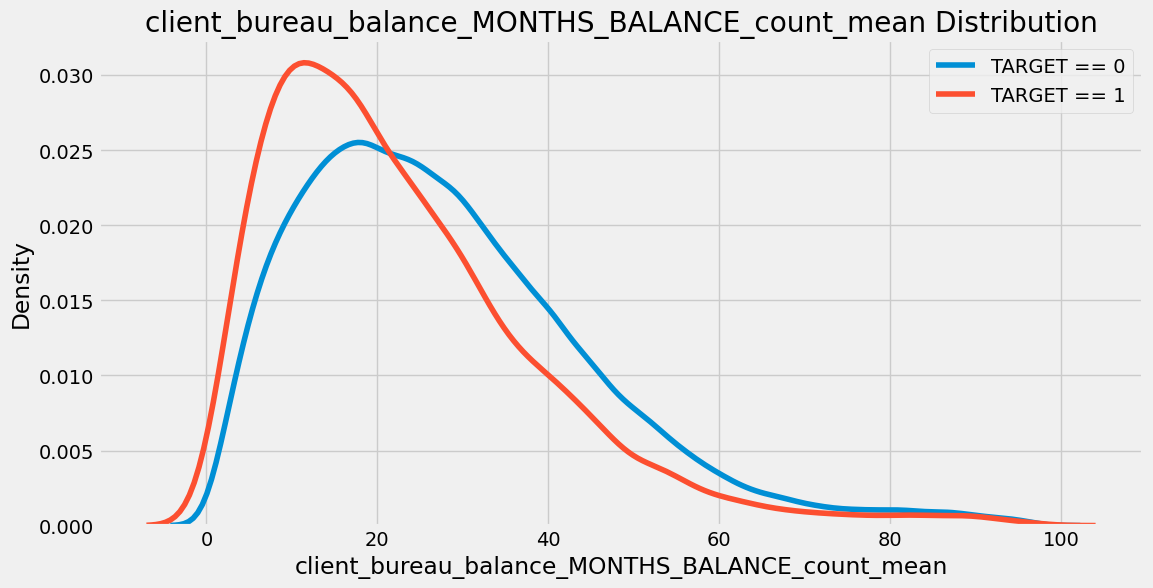

In [61]:
kde_target(var_name='client_bureau_balance_MONTHS_BALANCE_count_mean', df=train)

이 변수는 각 클라이언트의 대출당 월 평균 레코드 수를 나타냅니다. 예를 들어, 한 고객이 월별 데이터에 3, 4, 5개의 레코드가 있는 3개의 이전 대출을 가지고 있는 경우, 이 변수의 값은 4가 됩니다. 분포를 보면 대출 1건당 월평균 기록이 많은 고객일수록 홈크레디트로 대출금을 상환할 가능성이 높았습니다. 이 값을 너무 많이 읽지는 않지만, 이전에 신용 기록이 더 많은 고객이 일반적으로 대출을 상환할 가능성이 더 높다는 것을 나타낼 수 있습니다.

The correlation between bureau_CREDIT_ACTIVE_Active_count_norm and the TARGET is 0.0774
Median value for loan that was not repaid = 0.5000
Median value for loan that was repaid     = 0.3636


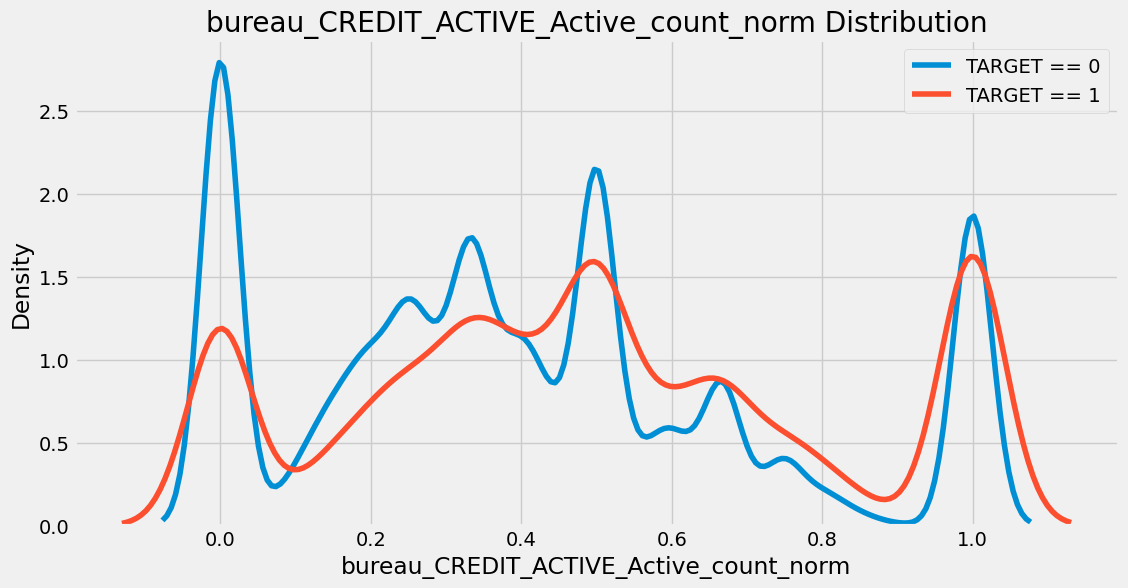

In [62]:
kde_target(var_name = 'bureau_CREDIT_ACTIVE_Active_count_norm', df=train)

이런 분포는 도처에 널려 있습니다. 이 변수는 Credit_ACTIVE 값이 Active인 이전 대출의 수를 클라이언트에 대한 이전 대출의 총 수로 나눈 값입니다. 여기서의 상관관계는 너무 약해서 우리가 어떤 결론을 도출해야 한다고 생각하지 않습니다!

#### Collinear Variables

- 변수와 대상의 상관 관계뿐만 아니라 각 변수와 다른 모든 변수의 상관 관계도 계산할 수 있습니다. 이를 통해 데이터에서 제거해야 할 매우 선형적인 변수가 있는지 확인할 수 있습니다.

- 다른 변수와 상관 관계가 0.8보다 큰 변수를 찾습니다.


In [63]:
threshold = 0.8
above_threshold_vars={}
for col in corrs:
  above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

이러한 고도로 상관된 변수 쌍 각각에 대해 변수 중 하나만 제거하려고 합니다. 다음 코드는 각 쌍 중 하나만 추가하여 제거할 변수 집합을 만듭니다.

In [64]:
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

for key, value in above_threshold_vars.items():
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)

cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  134


교육 및 테스트 데이터 세트 모두에서 이러한 열을 제거할 수 있습니다. 이러한 변수를 제거한 후의 성능과 이러한 변수(이전에 저장한 원시 csv 파일)를 유지하는 성능을 비교해야 합니다.

In [65]:
train_corrs_removed = train.drop(columns = cols_to_remove)
test_corrs_removed = test.drop(columns = cols_to_remove)

print('Training Corrs Removed Shape: ', train_corrs_removed.shape)
print('Testing Corrs Removed Shape: ', test_corrs_removed.shape)

Training Corrs Removed Shape:  (307511, 199)
Testing Corrs Removed Shape:  (48744, 198)


In [66]:
train_corrs_removed.to_csv('train_bureau_corrs_removed.csv', index = False)
test_corrs_removed.to_csv('test_bureau_corrs_removed.csv', index=False)

# Modeling

- 이러한 새로운 데이터 세트의 성능을 실제로 테스트하기 위해 머신 러닝에 사용해 보겠습니다! 여기에서는 다른 노트북에서 개발한 기능을 사용하여 기능을 비교합니다(상관성이 높은 변수가 제거된 원시 버전). 우리는 이런 종류의 실험을 실행할 수 있으며, 경쟁사에 제출할 때 이 기능에 포함된 응용프로그램 데이터의 성능만 제어할 수 있습니다. 해당 성능을 이미 기록했으므로 제어 장치와 두 가지 테스트 조건을 나열할 수 있습니다:

- 모든 데이터 세트에 대해 아래에 표시된 모델(정확한 하이퍼 파라미터 포함)을 사용합니다.

  - control: 응용 프로그램 파일의 데이터만 표시됩니다.
  - test 1: 응용 프로그램 파일의 데이터와 Bureau_balance 파일에서 기록된 모든 데이터
  - test 2: 응용 프로그램 파일의 데이터와 bookief_balance 파일에서 모든 데이터가 기록되고 상관 관계가 높은 변수가 제거되었습니다.


In [67]:
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import gc
import matplotlib.pyplot as plt

In [83]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):
      
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [84]:
def plot_feature_importances(df):
  df = df.sort_values('importance',ascending = False).reset_index()
  df['importance_normalized'] = df['importance']/df['importance'].sum()

  plt.figure(figsize = (10,6))
  ax = plt.subplot()

  ax.barh(list(reversed(list(df.index[:15]))),
          df['importance_normalized'].head(15),
          align = 'center', edgecolor = 'k')
  
  ax.set_yticks(list(reversed(list(df.index[:15]))))
  ax.set_yticklabels(df['feature'].head(15))

  plt.xlabel('Normalized Importance') 
  plt.title('Feature Importances')
  plt.show()

  return df

####Control
모든 실험의 첫 번째 단계는 관리 수준을 설정하는 것입니다. 이를 위해 위에 정의된 기능(그라데이션 부스팅 머신 모델을 구현하는 기능)과 단일 메인 데이터 소스(애플리케이션)를 사용합니다.


In [85]:
train_control = pd.read_csv('application_train.csv')
test_control = pd.read_csv('application_test.csv')

다행히도 함수를 작성하는 데 시간을 들인 후에는 함수를 사용하는 것이 간단합니다(이 노트에 중심 테마가 있는 경우에는 함수를 사용하여 작업을 단순하고 재현 가능하게 합니다!). 위의 함수는 경쟁사에 업로드할 수 있는 제출 데이터 프레임, 기능 중요도의 fi 데이터 프레임 및 검증 및 테스트 성능이 포함된 메트릭 데이터 프레임을 반환합니다.

In [86]:
submission, fi, metrics = model(train_control, test_control)

Training Data Shape:  (307511, 241)
Testing Data Shape:  (48744, 241)
[200]	train's auc: 0.798402	train's binary_logloss: 0.548246	valid's auc: 0.760094	valid's binary_logloss: 0.561937
[200]	train's auc: 0.798514	train's binary_logloss: 0.548241	valid's auc: 0.761102	valid's binary_logloss: 0.566424
[200]	train's auc: 0.799641	train's binary_logloss: 0.546889	valid's auc: 0.750166	valid's binary_logloss: 0.564526
[200]	train's auc: 0.798146	train's binary_logloss: 0.548898	valid's auc: 0.760594	valid's binary_logloss: 0.561966
[200]	train's auc: 0.797904	train's binary_logloss: 0.548939	valid's auc: 0.760804	valid's binary_logloss: 0.562506
[400]	train's auc: 0.827441	train's binary_logloss: 0.519709	valid's auc: 0.761454	valid's binary_logloss: 0.544715


In [87]:
metrics

,fold,train,valid
0,0,0.809955,0.760435
1,1,0.802473,0.761328
2,2,0.803744,0.750327
3,3,0.809674,0.760824
4,4,0.828844,0.761533
5,overall,0.810938,0.758904


- 교육 점수가 유효성 검사 점수보다 높기 때문에 컨트롤이 약간 오버핏됩니다. 정규화를 검토할 때 이후 노트북에서 이 문제를 해결할 수 있습니다(이 모델에서는 이미 reg_lambda 및 reg_alpha와 조기 중지를 사용하여 일부 정규화를 수행합니다).

- flot_feature_importance라는 다른 함수를 사용하여 형상 중요도를 시각화할 수 있습니다. 형상 중요도는 형상을 선택할 때 유용할 수 있습니다.


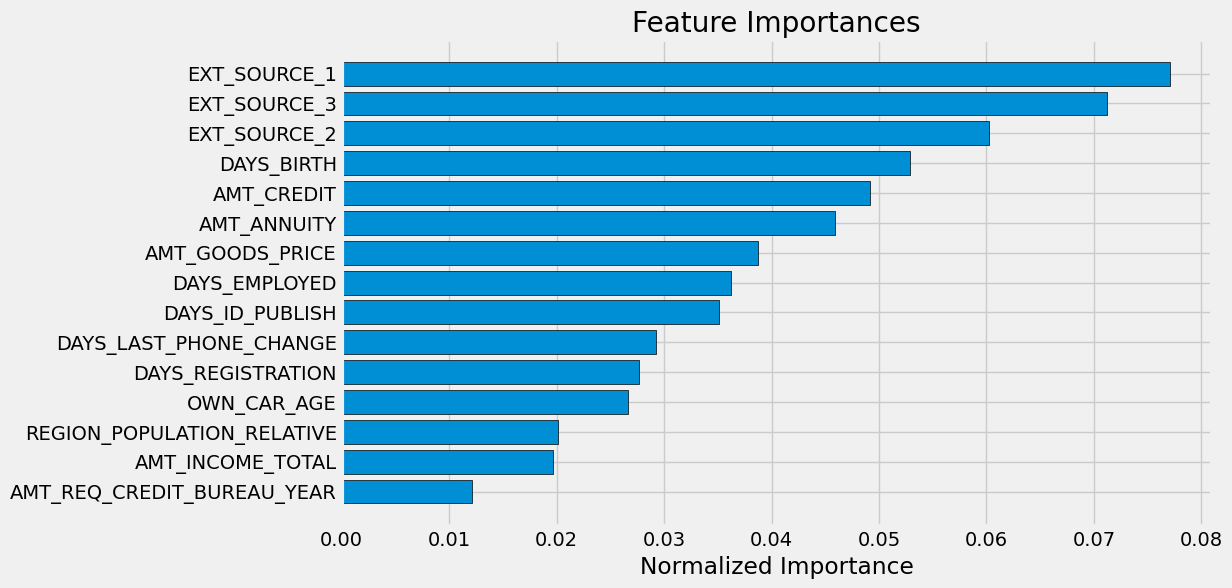

In [88]:
fi_sorted = plot_feature_importances(fi)

In [89]:
submission.to_csv('contorl.csv', index=False)

컨트롤은 경기에 제출할 때 0.745점을 받습니다

##### Test One
첫 번째 테스트를 진행하겠습니다. 우리는 대부분의 작업을 수행하는 기능에 데이터를 전달하기만 하면 됩니다.

In [90]:
submission_raw, fi_raw, metrics_raw = model(train,test)

Training Data Shape:  (307511, 452)
Testing Data Shape:  (48744, 452)
[200]	train's auc: 0.810592	train's binary_logloss: 0.536844	valid's auc: 0.766574	valid's binary_logloss: 0.552573
[200]	train's auc: 0.810124	train's binary_logloss: 0.537204	valid's auc: 0.766665	valid's binary_logloss: 0.557427
[200]	train's auc: 0.811563	train's binary_logloss: 0.535453	valid's auc: 0.761068	valid's binary_logloss: 0.553559
[200]	train's auc: 0.809655	train's binary_logloss: 0.53792	valid's auc: 0.767523	valid's binary_logloss: 0.552271
[200]	train's auc: 0.809973	train's binary_logloss: 0.537346	valid's auc: 0.767236	valid's binary_logloss: 0.553034


In [91]:
metrics_raw

,fold,train,valid
0,0,0.825534,0.767082
1,1,0.827177,0.767108
2,2,0.813405,0.761310
3,3,0.825458,0.768238
4,4,0.814424,0.767607
5,overall,0.821200,0.766260


이러한 수치를 바탕으로 설계된 기능이 제어 케이스보다 더 나은 성능을 발휘합니다. 그러나 이보다 더 나은 검증 성능이 테스트 데이터로 이전되는지 여부를 판단하기 전에 예측을 리더보드에 제출해야 합니다.

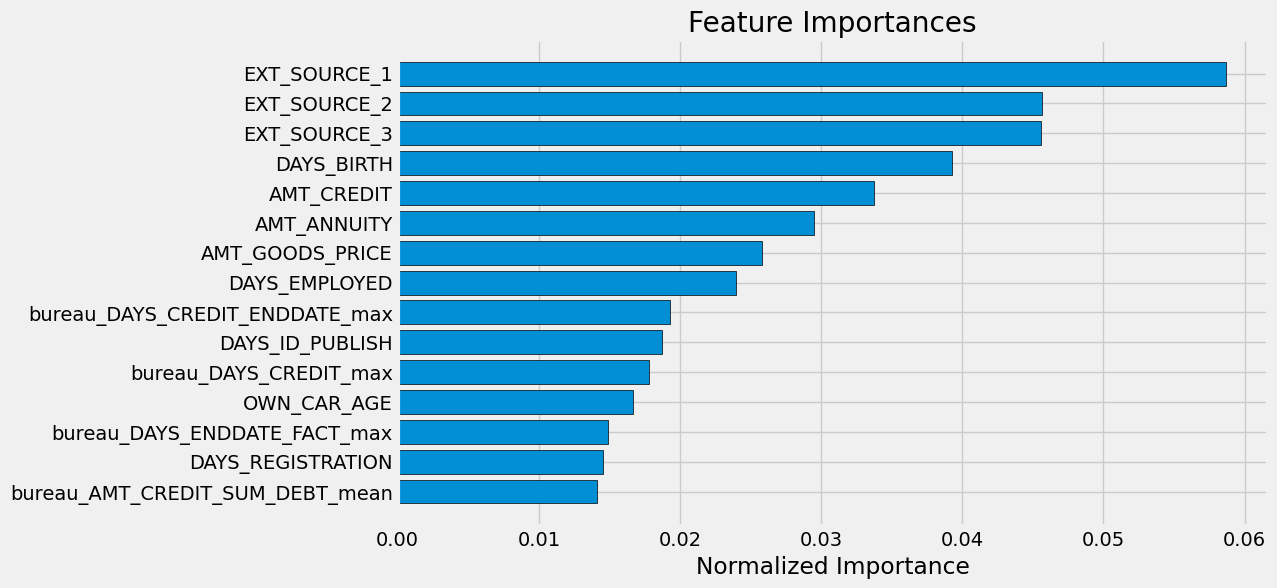

In [92]:
fi_raw_sorted = plot_feature_importances(fi_raw)

기능 개선 사항을 검토해 보면, 우리가 구성한 기능 중 몇 가지가 가장 중요한 기능인 것 같습니다. 이 노트북에서 만든 가장 중요한 100가지 기능 중에서 가장 중요한 기능의 비율을 알아보겠습니다. 그러나 단순히 원래 기능과 비교하는 것이 아니라 일회성으로 인코딩된 원래 기능과 비교해야 합니다. 이것들은 이미 (원래 데이터에서) fi에 기록되어 있습니다.

In [93]:
top_100 = list(fi_raw_sorted['feature'])[:100]
new_features = [x for x in top_100 if x not in list(fi['feature'])]
print('%% of Teop 100 Feautres created from the bureau data = %d.00' %len(new_features))


% of Teop 100 Feautres created from the bureau data = 51.00


상위 100개 기능 중 절반 이상이 저희가 만들었습니다! 그것은 우리가 한 모든 노력이 가치가 있다는 확신을 줄 것입니다.

In [94]:
submission_raw.to_csv('test_one.csv', index = False)

테스트 1은 경기에 제출할 때 0.759점을 받습니다.

####Test Two
쉬웠으니까 한 번 더 뛰자구요! 이전과 동일하지만 매우 공선형 변수가 제거되었습니다.

In [95]:
submission_corrs, fi_corrs, metrics_corr = model(train_corrs_removed, test_corrs_removed)

Training Data Shape:  (307511, 318)
Testing Data Shape:  (48744, 318)
[200]	train's auc: 0.806336	train's binary_logloss: 0.540883	valid's auc: 0.764055	valid's binary_logloss: 0.555785
[200]	train's auc: 0.806675	train's binary_logloss: 0.540666	valid's auc: 0.765081	valid's binary_logloss: 0.559934
[400]	train's auc: 0.839304	train's binary_logloss: 0.507642	valid's auc: 0.764703	valid's binary_logloss: 0.539294
[200]	train's auc: 0.807923	train's binary_logloss: 0.539039	valid's auc: 0.756987	valid's binary_logloss: 0.557198
[200]	train's auc: 0.80635	train's binary_logloss: 0.540956	valid's auc: 0.764428	valid's binary_logloss: 0.555348
[200]	train's auc: 0.806085	train's binary_logloss: 0.540942	valid's auc: 0.764368	valid's binary_logloss: 0.556499


In [96]:
metrics_corr

,fold,train,valid
0,0,0.822193,0.764764
1,1,0.825926,0.765381
2,2,0.824674,0.757214
3,3,0.813936,0.765052
4,4,0.819610,0.764649
5,overall,0.821268,0.763382


이러한 결과는 관리보다는 낫지만 원시 피쳐보다는 약간 낮습니다.

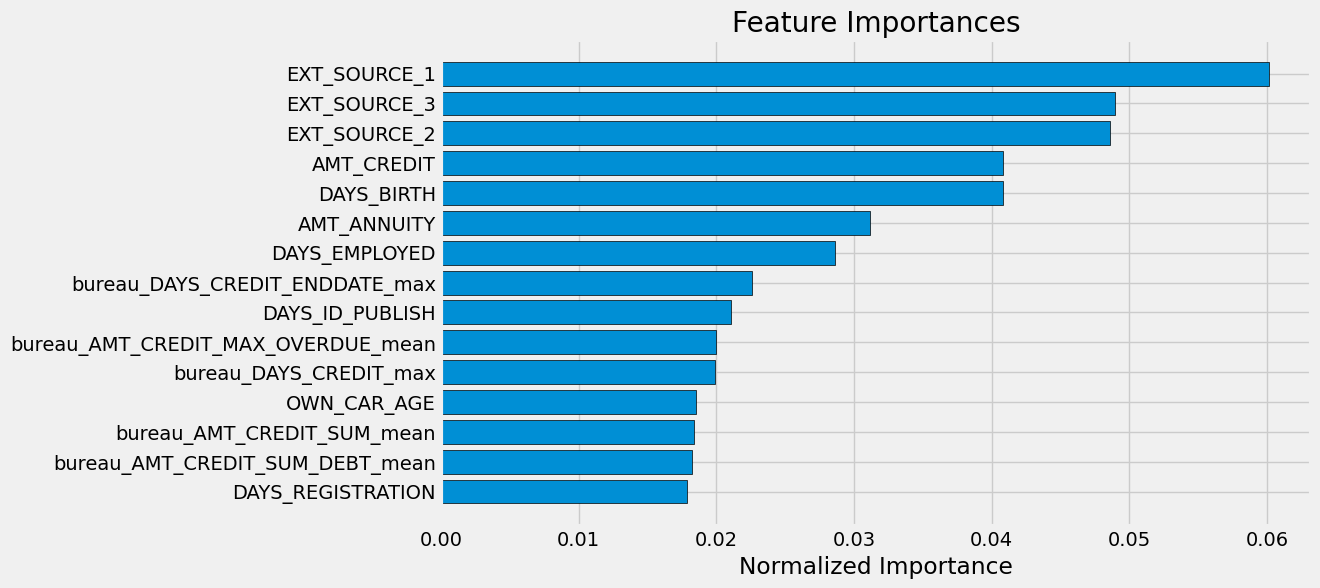

In [97]:

fi_corrs_sorted = plot_feature_importances(fi_corrs)

In [98]:
submission_corrs.to_csv('test_two.csv', index=False)

테스트 2는 경기에 제출할 때 0.753점을 받습니다.

#Results

- 그 모든 작업 후에, 우리는 추가 정보를 포함하는 것이 성능을 향상시켰다고 말할 수 있습니다! 이 모델은 확실히 데이터에 최적화되지 않았지만 계산된 기능을 사용할 때 원래 데이터 세트보다 눈에 띄게 개선되었습니다. 성과를 공식적으로 요약해 보겠습니다:

- 실험 열차 AUC 검증 AUC 테스트 AUC
제어 0.8150.7600.745
검정 1 0.8370.7670.759
검정 2개 0.826 0.765 0.753
이러한 점수는 노트북의 실행에 따라 변경될 수 있습니다. 하지만 저는 일반적인 주문이 바뀌는 것을 보지 못했습니다.)

- 우리의 모든 노력은 원래 테스트 데이터보다 0.014 ROCAUC의 작은 개선으로 이어집니다. 고도로 공선형 변수를 제거하면 성능이 약간 저하되므로 피쳐 선택을 위한 다른 방법을 고려하려고 합니다. 또한, 우리가 만든 기능 중 일부는 모델에 의해 판단되는 가장 중요한 기능 중 하나라고 말할 수 있습니다.

- 이와 같은 경쟁에서 이 크기의 개선만으로도 리더보드에서 100개의 자리를 차지할 수 있습니다. 이 노트북과 같이 여러 가지 작은 개선을 통해 점차 더 나은 성능을 달성할 수 있습니다. 저는 다른 사람들이 이 결과를 사용하여 스스로 개선할 것을 권장하며, 다른 사람들을 돕기 위해 제가 취한 조치를 계속 문서화할 것입니다.

#Next Step
앞으로 이 노트북에서 개발한 기능을 다른 데이터 세트에서 사용할 수 있습니다. 모델에 사용할 다른 4개의 데이터 파일이 남아 있습니다! 다음 노트북에서는 이러한 다른 데이터 파일의 정보(홈 크레딧의 이전 대출에 대한 정보 포함)를 교육 데이터에 통합합니다. 그런 다음 동일한 모델을 구축하고 더 많은 실험을 실행하여 기능 엔지니어링의 효과를 확인할 수 있습니다. 이 경쟁에서 더 많은 일을 해야 하고, 더 많은 성과를 내야 합니다! 다음 공책에서 뵙겠습니다.